## Monte Carlo - Forecasting Stock Prices - Part III

*Suggested Answers follow (usually there are multiple ways to solve a problem in Python).*

Forecasting Future Stock Prices – continued:

[*********************100%%**********************]  1 of 1 completed


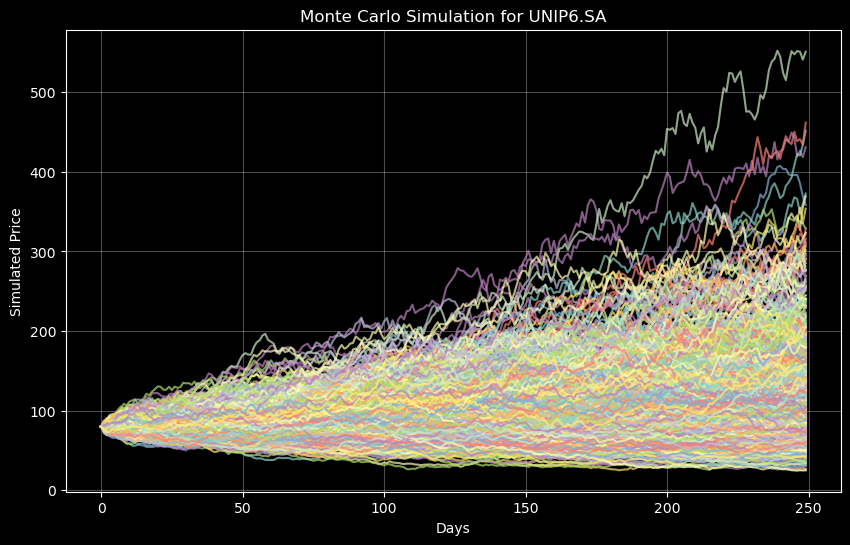

VaR 5%: -34.79%
Expected Shortfall 5%: -46.35%
Probability of return above 20%: 0.623
Decision: Invest based on Monte Carlo analysis.


In [2]:
import numpy as np  
import pandas as pd  
import yfinance as yf  
from scipy.stats import norm  
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


plt.style.use('dark_background')


ticker = 'UNIP6.SA'  
start_date = "2015-01-01"  
end_date = "2023-01-01"  


data = yf.download(ticker, start=start_date, end=end_date)
prices = data['Close']


log_returns = np.log(1 + data['Close'].pct_change())
u = log_returns.mean()  # Mean of returns
var = log_returns.var()  # Variance of returns
drift = u - (0.5 * var)  # Drift
stdev = log_returns.std()  # Standard deviation of returns

# =============================================================== Monte Carlo Simulation
t_intervals = 250  # Simulation length (days)
iterations = 1000 

# Aligning dimensions
daily_returns = np.exp(
    drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations))
)


last_price = prices.iloc[-1]  # Last known price
price_paths = np.zeros_like(daily_returns)
price_paths[0] = last_price

for t in range(1, t_intervals):
    price_paths[t] = price_paths[t - 1] * daily_returns[t]


final_prices = price_paths[-1]
initial_price = last_price
returns = (final_prices - initial_price) / initial_price * 100  # Returns in percentage

# Normalizing frequency to probability
bins = 30
hist, bin_edges = np.histogram(returns, bins=bins, density=True)  # `density=True` normalizes data
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers


hist_df = pd.DataFrame({
    'Final Return (%)': bin_centers,
    'Probability': hist
})


fig = px.bar(
    hist_df,
    x='Final Return (%)',
    y='Probability',
    title="Final Returns Probability Distribution",
    labels={'Final Return (%)': 'Final Return (%)', 'Probability': 'Probability'},
    template="plotly_dark"  
)


fig.add_vline(
    x=0, 
    line=dict(color="red", dash="dash"), 
    annotation_text="Initial Price (0%)",
    annotation_position="top left"
)


fig.show()

plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.7)  
plt.title(f"Monte Carlo Simulation for {ticker}", color='white')
plt.xlabel("Days", color='white')
plt.ylabel("Simulated Price", color='white')
plt.grid(alpha=0.3)
plt.show()

# Value at Risk (VaR) for a 5% confidence level
confidence_level = 0.05
var_5 = np.percentile(returns, confidence_level * 100)

es_5 = returns[returns <= var_5].mean()

print(f"VaR 5%: {var_5:.2f}%")  # Maximum expected loss
print(f"Expected Shortfall 5%: {es_5:.2f}%")  # Average expected loss

# Decision based on the probability of return above threshold
threshold = 20  # %
prob_positive = (returns > threshold).mean()
print(f"Probability of return above {threshold}%:", prob_positive)
if prob_positive > 0.6:  # 60% chance of return above the limit
    print("Decision: Invest based on Monte Carlo analysis.")
else:
    print("Decision: Do not invest due to high risk or low return expectation.")

# Answer the question at each point: "What is the probability that the final return will be less than or equal to X%?"
hist_df['Cumulative Probability'] = hist_df['Probability'].cumsum() / hist_df['Probability'].sum()

fig = px.line(
    hist_df,
    x='Final Return (%)',
    y='Cumulative Probability',
    title="Cumulative Probability of Final Returns",
    labels={'Final Return (%)': 'Final Return (%)', 'Cumulative Probability': 'Cumulative Probability'},
    template="plotly_dark"  
)
fig.show()
